# Precipitation

## Overview

- **Main ideas:**
    - This notebook makes the PERSIANN-CDR `daily` precipitation data spatially compatible with ERA-INTERIM data grid: 
        - PERSIANN-CDR:
            - lat: 480, lon: 1440; 0.25 x 0.25 degrees; not global because latitude is between 60S and 60N.
        - ERA-INTERIM: 
            - lat: 161, lon: 480; 0.75 x 0.75 degrees; latitude between 60S and 60N.     
    - [Regridding overview](https://climatedataguide.ucar.edu/climate-data-tools-and-analysis/regridding-overview).
    - [ESMP : ESMF Python interface](https://www.earthsystemcog.org/projects/esmp/).

## Initial setup

In [16]:
# Load packages
import sys
import glob
import os
import warnings
import progressbar
import contextlib

import xarray as xr
import xesmf as xe
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import pandas as pd

from dask.diagnostics import ProgressBar

warnings.filterwarnings("ignore")
xr.set_options(display_style="text")

%matplotlib inline

In [2]:
print("Python:", sys.version)
print("Xarray:", xr.__version__)
print("Pandas:", pd.__version__)

Python: 3.7.7 (default, Mar 26 2020, 15:48:22) 
[GCC 7.3.0]
Xarray: 0.16.0
Pandas: 1.0.2


In [3]:
# My repository.
repository = "/home/alex/Dropbox/repositories/cdlearn/"

In [4]:
%%time

# Include once my repository in the path for searching libraries.
if repository not in sys.path:
    sys.path.append(repository)
    
# Work in progress.
from cdlearn.maps import south_america_months

CPU times: user 1.53 s, sys: 148 ms, total: 1.68 s
Wall time: 1.73 s


In [5]:
# Original data.
MAIN_FOLDER = "/media/alex/ALEXDATA/data_sets/PERSIANN_CDR/"

# Year in a folder.
ANNUAL_DATA_FOLDERS = sorted([
    os.path.join(MAIN_FOLDER, YEAR) for YEAR in os.listdir(MAIN_FOLDER) 
    if "MSUM" not in YEAR
]) 

In [6]:
# South America.
loni, lonf, lati, latf = -90, -30, -60, 20

## Explore single file

In [7]:
# First time step for data of precipitation.
FILE_PATH = os.path.join(
    ANNUAL_DATA_FOLDERS[0], sorted(os.listdir(ANNUAL_DATA_FOLDERS[0]))[0]
)

# Lazy load.
DS = xr.open_dataset(
    FILE_PATH,
    drop_variables=["lon_bnds", "lat_bnds"]
)

# My standard.
DS = DS.transpose("time", "lat", "lon")

# Show it.
print(DS)

<xarray.Dataset>
Dimensions:        (lat: 480, lon: 1440, time: 1)
Coordinates:
  * time           (time) datetime64[ns] 1983-01-01
  * lat            (lat) float32 59.875 59.625 59.375 ... -59.625 -59.875
  * lon            (lon) float32 0.125 0.375 0.625 ... 359.375 359.625 359.875
Data variables:
    precipitation  (time, lat, lon) float32 ...
Attributes:
    datetime:                   1983-01-01
    Conventions:                CF-1.6
    title:                      NOAA Climate Data Record (CDR) of Precipitati...
    comment:                    Daily PERSIANN-CDR precipitation estimates fo...
    source:                     GRIDSAT-B1.1983.01.01.00.v02r01.nc,GRIDSAT-B1...
    Metadata_Conventions:       CF-1.6,Unidata Dataset Discovery v1.0, NOAA C...
    standard_name_vocabulary:   CF Standard Name Table (v26, 08 November 2013)
    id:                         PERSIANN-CDR_v01r01_19830101_c20140523.nc
    naming_authority:           gov.noaa.ncdc
    date_created:               20

In [8]:
# Into memory.
with ProgressBar():
    DS = DS.load()

## Create regridder file

In [9]:
# In accordance with ERA-INTERIM pos-processed data (after shifting longitudes from 0 ... 360
# to -180 ... 180).
NEW_GRID = xr.Dataset({
    "lat": (["lat"], np.arange(90.00, -90.01, -0.75)),
    "lon": (["lon"], np.arange(-180.00, 180.00, 0.75)),
})

# Show it.
print(NEW_GRID)

<xarray.Dataset>
Dimensions:  (lat: 241, lon: 480)
Coordinates:
  * lat      (lat) float64 90.0 89.25 88.5 87.75 ... -87.75 -88.5 -89.25 -90.0
  * lon      (lon) float64 -180.0 -179.2 -178.5 -177.8 ... 177.8 178.5 179.2
Data variables:
    *empty*


**DANGER ZONE! INTENSIVE OPERATIONS! The regridder file was created previously using LFA aerossol server.**

In [10]:
%%time

# Regridder object.
REGRIDDER = xe.Regridder(
    ds_in=DS, 
    ds_out=NEW_GRID, 
    method="bilinear", 
    periodic=True, 
    reuse_weights=True,
    filename="regridder_p.nc"
)

Reuse existing file: regridder_p.nc
CPU times: user 449 ms, sys: 346 ms, total: 795 ms
Wall time: 801 ms


In [11]:
%%time

# Regridded data.
DSreg = REGRIDDER(DS)

# Show it.
print(DSreg)

using dimensions ('lat', 'lon') from data variable precipitation as the horizontal dimensions for this dataset.
<xarray.Dataset>
Dimensions:        (lat: 241, lon: 480, time: 1)
Coordinates:
  * time           (time) datetime64[ns] 1983-01-01
  * lon            (lon) float64 -180.0 -179.2 -178.5 ... 177.8 178.5 179.2
  * lat            (lat) float64 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
Data variables:
    precipitation  (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    regrid_method:  bilinear
CPU times: user 222 ms, sys: 11.6 ms, total: 233 ms
Wall time: 250 ms


## Compare original and regridded files

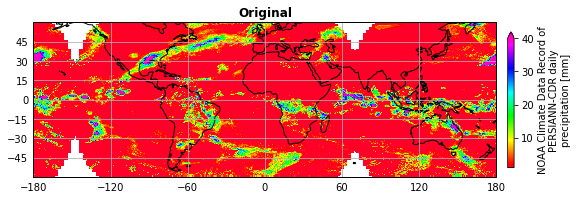

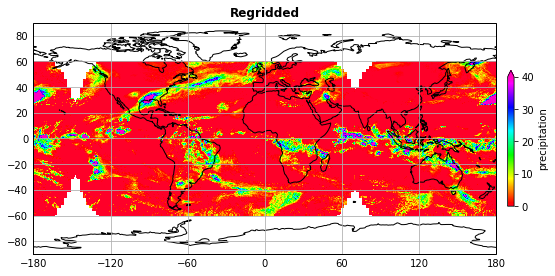

In [12]:
# Make global map for original data.
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
mapa = DS.precipitation.plot(
    ax=ax, 
    vmin=1, vmax=40,
    cmap=plt.cm.gist_rainbow, 
    cbar_kwargs={"shrink": 0.5,
                 "pad": 0.020,
                 "extend": "max"})
ax.set_title("Original", weight="bold");

# Make global map for regridded data.
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
mapa = DSreg.precipitation.plot(
    ax=ax, 
    vmin=0, vmax=40,
    cmap=plt.cm.gist_rainbow, 
    cbar_kwargs={"shrink": 0.5,
                 "pad": 0.020,
                 "extend": "max"})
ax.set_title("Regridded", weight="bold");

## Create regridded files for all years

**It takes a lot of time to make all files (~1h30min)!**

In [17]:
%%time

# All original files.
FILES_PATHS = sorted([
    os.path.join(MAIN_FOLDER, FOLDER, FILE) for FOLDER in ANNUAL_DATA_FOLDERS 
         for FILE in os.listdir(FOLDER)
         if ".nc" in FILE
])

# Loop over input files.
with progressbar.ProgressBar(max_value=len(FILES_PATHS)) as p:
    index=0
    for FILE_PATH in FILES_PATHS:
    
        # Regridded data together with original ones.
        OUTPUT_FOLDER = os.path.dirname(FILE_PATH)
    
        # Extract input file name without extension.
        NAME = os.path.basename(FILE_PATH) # File name with extension.
        NAME = os.path.splitext(NAME)[0]   # File name withou extension.
    
        # Output file path.
        OUT_FILE_NAME = NAME + "_regridded" + ".nc4"
        OUT_FILE_PATH = os.path.join(OUTPUT_FOLDER, OUT_FILE_NAME)   
    
        # Continue only if data file does not exist yet.
        if not os.path.isfile(OUT_FILE_PATH):
                
            # Lazy load.
            DS = xr.open_dataset(
                FILE_PATH,
                drop_variables=["lon_bnds", "lat_bnds"]
            )

            # My standard.
            DS = DS.transpose("time", "lat", "lon")
        
            # Regrid data without printing messages.    
            with open(os.devnull, "w") as devnull:
                with contextlib.redirect_stdout(devnull):
                    DSreg = REGRIDDER(DS)
              
            # Export regridded data into the output folder. 
            DSreg.to_netcdf(path=OUT_FILE_PATH)

            index += 1
            p.update(index)

100% (13574 of 13574) |##################| Elapsed Time: 1:25:32 Time:  1:25:32


CPU times: user 1h 13min 36s, sys: 2min 47s, total: 1h 16min 24s
Wall time: 1h 25min 33s
